# Random Forests and ExtraTrees

## Random Forests

With bagged decision trees, we generate many different trees on pretty similar data. These trees are **strongly correlated** with one another. Because these trees are correlated with one another, they will have high variance. Looking at the variance of the average of two random variables $T_1$ and $T_2$:

$$
\begin{eqnarray*}
Var\left(\frac{T_1+T_2}{2}\right) &=& \frac{1}{4}\left[Var(T_1) + Var(T_2) + 2Cov(T_1,T_2)\right]
\end{eqnarray*}
$$

If $T_1$ and $T_2$ are highly correlated, then the variance will about as high as we'd see with individual decision trees. By "de-correlating" our trees from one another, we can drastically reduce the variance of our model.

That's the difference between bagged decision trees and random forests! We're going to do the same thing as before, but we're going to de-correlate our trees. This will reduce our variance (at the expense of a small increase in bias) and thus should greatly improve the overall performance of the final model.

### So how do we "de-correlate" our trees?
Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each split in the learning process, a **random subset of the features**. This process is sometimes called the *random subspace method*.

The reason for doing this is the correlation of the trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be used in many/all of the bagged decision trees, causing them to become correlated. By selecting a random subset of features at each split, we counter this correlation between base trees, strengthening the overall model.

For a problem with $p$ features, it is typical to use:

- $\sqrt{p}$ (rounded down) features in each split for a classification problem.
- $p/3$ (rounded down) with a minimum node size of 5 as the default for a regression problem.

While this is a guideline, Hastie and Tibshirani (authors of Introduction to Statistical Learning and Elements of Statistical Learning) have suggested this as a good rule in the absence of some rationale to do something different.

Random forests, a step beyond bagged decision trees, are **very widely used** classifiers and regressors. They are relatively simple to use because they require very few parameters to set and they perform pretty well.
- It is quite common for interviewers to ask how a random forest is constructed or how it is superior to a single decision tree.

--- 

## Extremely Randomized Trees (ExtraTrees)
Adding one more step of randomization (and thus de-correlation) yields extremely randomized trees, or _ExtraTrees_. These are trained using bagging (sampling of observations) and the random subspace method (sampling of features), but an additional layer of randomness is introduced. Instead of computing the locally optimal feature/split combination (based on, e.g., information gain or the Gini impurity) for each feature under consideration, a random value is selected for the split. This value is selected from the feature's empirical range.

This further reduces the variance, but causes an increase in bias. If you're considering using ExtraTrees, you might consider this to be a hyperparameter you can tune. Build an ExtraTrees model and a Random Forest model, then compare their performance!

That's exactly what we'll do below.

## Import libraries
- `pandas`
- `numpy`
- `GridSearchCV`, `train_test_split` and `cross_val_score` from `sklearn`'s `model_selection` module 
- `RandomForestClassifier` and `ExtraTreesClassifier` from `sklearn`'s `ensemble` module 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

## Load Data

Load `train.csv` and `test.csv` from Kaggle into `DataFrames`.

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train = pd.read_csv('data/train.csv')
train = train[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Name']]
train.columns = [c.lower() for c in train.columns]

In [4]:
train.head()

,survived,pclass,sex,age,fare,embarked,name
0,0,3,male,22.0,7.2500,S,"Braund, Mr. Owen Harris"
1,1,1,female,38.0,71.2833,C,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,1,3,female,26.0,7.9250,S,"Heikkinen, Miss. Laina"
3,1,1,female,35.0,53.1000,S,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,0,3,male,35.0,8.0500,S,"Allen, Mr. William Henry"


In [5]:
train = train.rename(columns={
    'survived': 'mummified', 
    'pclass': 'status',
    'fare': 'wealth',
    'embarked': 'village'
})

train.head(1)

train['mummified'] = train['mummified'].replace({0:1, 1: 0})

train.head(1)

,mummified,status,sex,age,wealth,village,name
0,1,3,male,22.0,7.25,S,"Braund, Mr. Owen Harris"


In [6]:
train['title'] = train['name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
train = train.drop('name', axis=1)
train['title'].value_counts()

train.groupby('title')['mummified'].mean().sort_values()

train['title'] = train['title'].replace({
    'the Countess': None,
    'Ms': 'Peasant', 
    'Mme': None,
    'Mlle': None,
    'Lady': 'Nobility',
    'Sir': 'High Priest',
    'Mrs': None,
    'Miss': 'Peasant',
    'Master': None,
    'Major': 'Guard',
    'Col': 'Guard',
    'Dr': 'Healer',
    'Mr': 'Peasant',
    'Jonkheer': None,
    'Don': 'Priest',
    'Rev': 'Pharaoh',
    'Capt': 'Pharaoh'
})

train.head()

,mummified,status,sex,age,wealth,village,title
0,1,3,male,22.0,7.2500,S,Peasant
1,0,1,female,38.0,71.2833,C,None
2,0,3,female,26.0,7.9250,S,Peasant
3,0,1,female,35.0,53.1000,S,None
4,1,3,male,35.0,8.0500,S,Peasant


In [7]:
target = 'mummified'
y = train[target]
X = train.drop(target, axis=1)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
from sklearn_pandas import DataFrameMapper, CategoricalImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

mapper = DataFrameMapper([
    (['status'], SimpleImputer()),
    ('sex', [CategoricalImputer(), LabelBinarizer()]),
    (['age'], SimpleImputer()),
    (['wealth'], SimpleImputer()),
    ('village', [CategoricalImputer(), LabelBinarizer()]),
    ('title', [CategoricalImputer(), LabelBinarizer()])
])

Z_train = mapper.fit_transform(X_train)
Z_test = mapper.transform(X_test)

In [10]:
np.mean(y_train)

0.6212574850299402

## Model instantiation

Create an instance of `RandomForestClassifier` and `ExtraTreesClassifier`.

In [11]:
rf = RandomForestClassifier(n_estimators=100)
et = ExtraTreesClassifier(n_estimators=100)

## Model Evaluation

Which one has a higher `cross_val_score`?

In [12]:
cross_val_score(rf, Z_train, y_train, cv=5)

array([0.76865672, 0.82835821, 0.74626866, 0.82706767, 0.84210526])

In [13]:
cross_val_score(et, Z_train, y_train, cv=5)

array([0.75373134, 0.80597015, 0.76865672, 0.81203008, 0.84210526])

In [14]:
rf.fit(Z_train, y_train)
rf.score(Z_test, y_test)

0.7982062780269058

## Grid Search

They're both pretty close performance-wise. We could Grid Search over both, but for the sake of time we'll go with `RandomForestClassifier`.

In [15]:
rf = RandomForestClassifier()
rf_params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 1, 3, 5],
    'min_samples_split': [2, 3, 4],
    'max_features': ['auto', 0.5, 0.8]
}

gs = GridSearchCV(rf, param_grid=rf_params, verbose=1)

gs.fit(Z_train, y_train)


/Users/max/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=1)]: Done 216 out of 216 | elapsed:   30.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [16]:
gs.best_params_

{'max_depth': 5,
 'max_features': 0.5,
 'min_samples_split': 2,
 'n_estimators': 300}

In [17]:
gs.best_score_

0.8263473053892215

In [18]:
gs.score(Z_train, y_train)

0.8682634730538922

In [19]:
gs.score(Z_test, y_test)

0.8251121076233184

In [20]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(mapper, gs.best_estimator_)

In [22]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('dataframemapper',
                 DataFrameMapper(default=False, df_out=False,
                                 features=[(['status'],
                                            SimpleImputer(add_indicator=False,
                                                          copy=True,
                                                          fill_value=None,
                                                          missing_values=nan,
                                                          strategy='mean',
                                                          verbose=0)),
                                           ('sex',
                                            [CategoricalImputer(copy=True,
                                                                fill_value='?',
                                                                missing_values='NaN',
                                                                strategy='most_freque

In [23]:
pipe.named_steps

{'dataframemapper': DataFrameMapper(default=False, df_out=False,
                 features=[(['status'],
                            SimpleImputer(add_indicator=False, copy=True,
                                          fill_value=None, missing_values=nan,
                                          strategy='mean', verbose=0)),
                           ('sex',
                            [CategoricalImputer(copy=True, fill_value='?',
                                                missing_values='NaN',
                                                strategy='most_frequent'),
                             LabelBinarizer(neg_label=0, pos_label=1,
                                            sparse_output=False)]),
                           (['age'],
                            SimpleIm...
                           ('village',
                            [CategoricalImputer(copy=True, fill_value='?',
                                                missing_values='NaN',
                

In [24]:
pipe.named_steps['dataframemapper'].get_params()['features'][1][1][1].classes_

array(['female', 'male'], dtype='<U6')

In [25]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('mapper', mapper),
    ('random_forest', gs.best_estimator_)
])

pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.8251121076233184

In [26]:
pipe.named_steps

{'mapper': DataFrameMapper(default=False, df_out=False,
                 features=[(['status'],
                            SimpleImputer(add_indicator=False, copy=True,
                                          fill_value=None, missing_values=nan,
                                          strategy='mean', verbose=0)),
                           ('sex',
                            [CategoricalImputer(copy=True, fill_value='?',
                                                missing_values='NaN',
                                                strategy='most_frequent'),
                             LabelBinarizer(neg_label=0, pos_label=1,
                                            sparse_output=False)]),
                           (['age'],
                            SimpleIm...
                           ('village',
                            [CategoricalImputer(copy=True, fill_value='?',
                                                missing_values='NaN',
                         

In [27]:
cross_val_score(pipe, X_train, y_train, cv=4)

array([0.77380952, 0.88622754, 0.80838323, 0.8373494 ])

In [28]:
preds = pd.DataFrame({
    'y_test': y_test, 
    'y_hat': pipe.predict_proba(X_test)[:, 1]
})
preds.sample()

,y_test,y_hat
33,1,0.822798


In [29]:
np.where(preds['y_hat'] >= 0.5, 1, 0)

array([1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1])

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(preds.y_test, preds.y_hat)

0.8807227905416736

In [31]:
X_train.sample().to_dict(orient='list')

new = pd.DataFrame({
    'status': [1],
    'sex': ['female'],
    'age': [12],
    'wealth': [7],
    'village': ['S'],
    'title': ['Peasant']}
)

new

,status,sex,age,wealth,village,title
0,1,female,12,7,S,Peasant


In [32]:
pipe.predict_proba(new)

array([[0.82109662, 0.17890338]])

In [33]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [34]:
preds = preds.sort_values('y_hat')
preds["rank"] = preds["y_hat"].rank(method='first') 
preds['height'] = 1
preds.head()

,y_test,y_hat,rank,height
319,0,0.012291,1.0,1
215,0,0.012402,2.0,1
218,0,0.013607,3.0,1
835,0,0.014044,4.0,1
716,0,0.018515,5.0,1


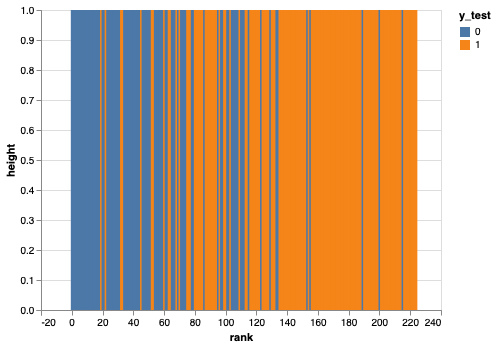

In [35]:
alt.Chart(preds).mark_bar().encode(x='rank', y='height', color='y_test:N')